<h1>Оглавление<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-loader" data-toc-modified-id="Data-loader-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data loader</a></span></li></ul></div>

# Подключение библиотек

In [1]:
import fiftyone as fo
import fiftyone.zoo as foz

# Download and load the validation split of COCO-2017
fo_dataset = foz.load_zoo_dataset("coco-2017", split="validation",
                               dataset_dir='/mnt/heap')

Found annotations at '/mnt/heap/raw/instances_val2017.json'
Images already downloaded
Existing download of split 'validation' is sufficient
Loading 'coco-2017' split 'validation'
 100% |███████████████| 5000/5000 [22.4s elapsed, 0s remaining, 242.0 samples/s]      
Dataset 'coco-2017-validation' created


session = fo.launch_app(dataset)

In [2]:
fo_dataset.compute_metadata()

## Data set

In [3]:
import torch
import fiftyone.utils.coco as fouc
from PIL import Image


class FiftyOneTorchDataset(torch.utils.data.Dataset):
    """A class to construct a PyTorch dataset from a FiftyOne dataset.
    
    Args:
        fiftyone_dataset: a FiftyOne dataset or view that will be used for training or testing
        transforms (None): a list of PyTorch transforms to apply to images and targets when loading
        gt_field ("ground_truth"): the name of the field in fiftyone_dataset that contains the 
            desired labels to load
        classes (None): a list of class strings that are used to define the mapping between
            class names and indices. If None, it will use all classes present in the given fiftyone_dataset.
    """

    def __init__(
        self,
        fiftyone_dataset,
        transforms=None,
        gt_field="ground_truth",
        classes=None,
    ):
        self.samples = fiftyone_dataset
        self.transforms = transforms
        self.gt_field = gt_field

        self.img_paths = self.samples.values("filepath")

        self.classes = classes
        if not self.classes:
            # Get list of distinct labels that exist in the view
            self.classes = self.samples.distinct(
                "%s.detections.label" % gt_field
            )

        if self.classes[0] != "background":
            self.classes = ["background"] + self.classes

        self.labels_map_rev = {c: i for i, c in enumerate(self.classes)}

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        sample = self.samples[img_path]
        metadata = sample.metadata
        img = Image.open(img_path).convert("RGB")

        boxes = []
        detections = sample[self.gt_field].detections
        img_has_person = 0
        for det in detections:
            category_id = self.labels_map_rev[det.label]
            coco_obj = fouc.COCOObject.from_detection(
                det, metadata, category_id=category_id,
            )
            x, y, w, h = coco_obj.bbox
            
            if det.label == 'person':
                boxes.append([x, y, x + w, y + h])
                img_has_person = 1

        target = {}
        '''
        print(boxes)
        print('==================================')
        box = sorted(boxes)[0]  
        print(box)
        '''
        box = sorted(boxes)[0]  
        target["box"] = torch.as_tensor(box, dtype=torch.float32)                              
        target["img_has_person"] = img_has_person
        target["img_path"] = img_path

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.img_paths)

    def get_classes(self):
        return self.classes

In [4]:
from fiftyone import ViewField as F

person_list = ["person"]
person_view = fo_dataset.filter_labels("ground_truth",
        F("label").is_in(person_list))

print(len(person_view))

2693


## Data loader

In [5]:
import torchvision.transforms as T

img_size = (256, 256)
train_transforms = T.Compose([T.Resize(img_size),
                              T.ToTensor()])
test_transforms = T.Compose([T.Resize(img_size),
                             T.ToTensor()])

In [6]:
# split the dataset in train and test set
train_view = person_view.take(len(person_view) * 0.75, seed=51)
test_view = person_view.exclude([s.id for s in train_view])

In [7]:
torch_dataset = FiftyOneTorchDataset(train_view, train_transforms,
        classes=person_list)
torch_dataset_test = FiftyOneTorchDataset(test_view, test_transforms, 
        classes=person_list)

In [8]:
len(torch_dataset)

2019

In [9]:
len(torch_dataset_test)

674

In [10]:
# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
        torch_dataset, batch_size=100)
    
data_loader_test = torch.utils.data.DataLoader(
        torch_dataset_test, batch_size=1, shuffle=False)

# Train loop

In [11]:
from itertools import product
from pytorch_helper import PyTorchHelper

In [12]:
loss_function_xy = torch.nn.MSELoss()
loss_function_bce = torch.nn.CrossEntropyLoss()

In [45]:
from pytorch_helper import PyTorchHelper

def find_hyperparameters(config):
    learning_rates = [1e-1]
    anneal_coeff = 0.2
    anneal_epochs = [5]
    regs = config['regs']
    optimizers = config['optimizers']

    batch_size = 64
    epoch_num = 6

    run_record = {} 
    
    helper = PyTorchHelper(8,  None)

    lenet_model = None
    val_loss = 8
    loss_history = None
    for lr, reg, anneal_epoch, optimizer in product(learning_rates, regs, anneal_epochs, optimizers):
        lenet_model = config['model']() # base_lenet()

        loss = None

        optimizer = optimizer(lenet_model.parameters(), lr=lr, weight_decay=reg)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=anneal_epoch, gamma=anneal_coeff)

        lenet_model, loss_history, val_loss = helper.train_model(config['model_name'],lenet_model, data_loader, data_loader_test, loss, optimizer, epoch_num, scheduler)

    return lenet_model, loss_history, val_loss

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision.models import resnet18

In [47]:
def net():
    model = resnet18(pretrained=True)
    model.fc = nn.Linear(in_features=512, out_features=5)
    return model

In [48]:
config = {
    'regs': [0.0001],
    'optimizers': [optim.SGD],
    'model': net,
    'model_name': 'best_lenet'    
}

In [49]:
from resource_monitor import ResourceMonitor
resourceMonitor = ResourceMonitor()

In [50]:
resourceMonitor.print_statistics('MB')

memory_allocated: 0.0
max_memory_allocated: 3748.98876953125
memory_reserved: 3978.0
max_memory_reserved: 3978.0


In [51]:
model, train_loss_history, val_loss_history = find_hyperparameters(config)

Start train:
memory_allocated: 42.69677734375
max_memory_allocated: 3748.98876953125
memory_reserved: 64.0
max_memory_reserved: 3978.0
Epoch 0/5
----------
Step 0/21 Loss 233.78273010253906
Step 1/21 Loss 217.16268920898438
Step 2/21 Loss 204.31390380859375
Step 3/21 Loss 199.2246856689453
Step 4/21 Loss 190.83331298828125
Step 5/21 Loss 182.46646118164062
Step 6/21 Loss 186.3039093017578
Step 7/21 Loss 182.19015502929688
Step 8/21 Loss 169.8984832763672
Step 9/21 Loss 157.3761444091797
Step 10/21 Loss 167.3141326904297
Step 11/21 Loss 149.3233642578125
Step 12/21 Loss 158.543701171875
Step 13/21 Loss 145.01950073242188
Step 14/21 Loss 144.6087646484375
Step 15/21 Loss 130.65313720703125
Step 16/21 Loss 128.99246215820312
Step 17/21 Loss 133.20101928710938
Step 18/21 Loss 130.6306610107422
Step 19/21 Loss 127.90497589111328
Step 20/21 Loss 116.83952331542969
Average loss train: 172.829178
Average loss test: 126.650017
memory_allocated: 86.72265625
max_memory_allocated: 3748.98876953125

In [52]:
from matplotlib import pyplot as plt

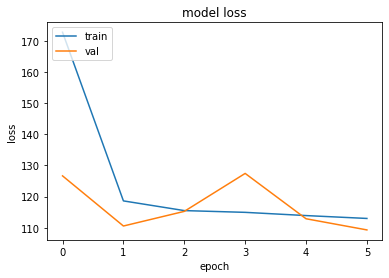

In [53]:
plt.plot(train_loss_history, label='train')
plt.plot(val_loss_history, label='val')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

In [54]:
resourceMonitor.print_statistics('MB')

memory_allocated: 0.0
max_memory_allocated: 3748.98876953125
memory_reserved: 3900.0
max_memory_reserved: 3978.0


# Visualization

In [26]:
import fiftyone as fo

def convert_torch_predictions(preds, det_id, s_id, w, h, classes):
    # Convert the outputs of the torch model into a FiftyOne Detections object
    dets = []
    #if preds[0] < 0.5:
     #   detections = fo.Detections(detections=dets)
      #  return detections, det_id
    
    # Parse prediction into FiftyOne Detection object
    x0,y0,x1,y1 = preds[1:]
    coco_obj = fouc.COCOObject(det_id, s_id, int(1), [x0, y0, x1-x0, y1-y0])
    det = coco_obj.to_detection((w,h), classes)
    dets.append(det)
    det_id += 1
        
    detections = fo.Detections(detections=dets)
        
    return detections, det_id

def add_detections(model, torch_dataset, view, field_name="predictions"):
    # Run inference on a dataset and add results to FiftyOne
    torch.set_num_threads(1)
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    print("Using device %s" % device)

    model.eval()
    model.to(device)
    image_paths = torch_dataset.img_paths
    classes = torch_dataset.classes
    det_id = 0
    
    with fo.ProgressBar() as pb:
        for img, targets in pb(torch_dataset):
            sample = view[targets["img_path"]]
            s_id = sample.id
            w = sample.metadata["width"]
            h = sample.metadata["height"]
            
            # Inference
            preds = model(img.unsqueeze(0).to(device))[0]
            
            detections, det_id = convert_torch_predictions(
                preds, 
                det_id, 
                s_id, 
                w, 
                h, 
                classes,
            )
            
            sample["predictions"] = detections
            sample.save()

In [27]:
add_detections(model, torch_dataset_test, fo_dataset)

Using device cuda
 100% |█████████████████| 674/674 [18.8s elapsed, 0s remaining, 36.3 samples/s]      


In [28]:
session = fo.launch_app(fo_dataset)